# Projeto de Análise de Sistemas por Quadripolos
**Disciplina**: Circuitos Elétricos 2 

**Aluna**: Gabriela Andrade

**Aluno**: Carolynne Ribeiro

**Aluno**: Daniel Loula

**Aluno**: Kildary Jonathan

**Aluno**: Mauro Sousa

**Professor**: Prof. Dr. Luiz Augusto Medeiros Martins Nobrega

**Data**: Pão


## Seção 1: Configuração Inicial
Nesta seção, são importadas as bibliotecas necessárias e definidas as constantes do sistema, como a frequência e a tensão do gerador.

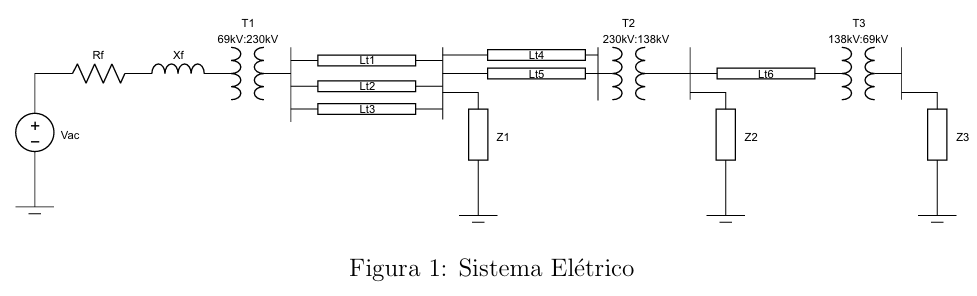

In [1]:
# Célula 1
import numpy as np
import matplotlib.pyplot as plt
import cmath

# Constantes do Sistema
f = 60
omega = 2 * np.pi * f
V_gerador = 69e3  # 69 kV RMS

## Seção 2: Parâmetros do Sistema
Definição dos parâmetros das linhas de transmissão, transformadores e cargas do sistema elétrico.

### Linhas de Transmissão

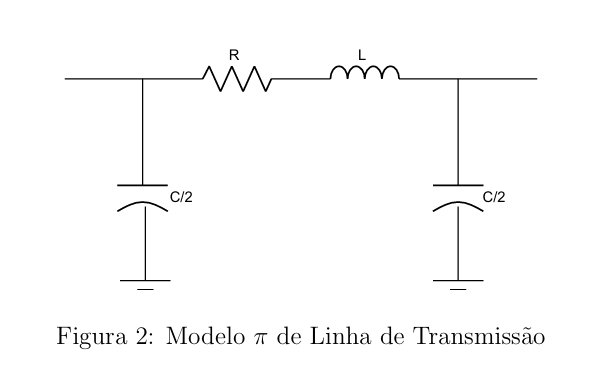

- **R_km**: Resistência por quilômetro (Ω/km)  
- **L_km**: Indutância por quilômetro (H/km)  
- **C_km**: Capacitância por quilômetro (F/km)  
- **Comprimentos**: Dicionário com os comprimentos das linhas em quilômetros.

### Transformadores

![image-2.png](attachment:image-2.png)

- **R1, X1**: Resistência e reatância do lado primário (Ω).  
- **Rm, Xm**: Resistência e reatância de magnetização (Ω).  
- **a**: Relação de transformação.

### Cargas
- **R**: Resistência da carga (Ω).  
- **L**: Indutância da carga (H).  

In [2]:
# Célula 2
# Linhas de Transmissão
R_km, L_km, C_km = 0.172, 2.18e-3, 0.0136e-6
comprimentos = {'LT1':80, 'LT2':80, 'LT3':80, 'LT4':100, 'LT5':100, 'LT6':90}

# Transformadores
trafo_params = {
    'T1': {'R1':7.6e-3, 'X1':3.8e-3, 'Rm':4320, 'Xm':5050},
    'T2': {'R1':33.9e-3, 'X1':0.85e-3, 'Rm':432000, 'Xm':505000},
    'T3': {'R1':0, 'X1':0, 'Rm':402000, 'Xm':607000}  # R1 e X1 definidos como 0 para compatibilidade com a função matriz_transformador
}

# Cargas
cargas = {
    'Z1': {'R':790, 'L':4.1},
    'Z2': {'R':137.55, 'L':0.75},
    'Z3': {'R':62.0, 'L':0.34}
}

## Seção 3: Funções para Matrizes ABCD
Implementação das funções para calcular as matrizes de transferência (ABCD) dos componentes do sistema:

1. **Linhas de Transmissão**: Modelo π.

$$
T_{LT} =
\begin{bmatrix}
1 + \frac{ZY}{2} & Z \\
Y \left( 1 + \frac{ZY}{4} \right) & 1 + \frac{ZY}{2}
\end{bmatrix}
$$

2. **Transformadores**: Modelo T.  
3. **Cargas**: Modelo de impedância série.  
4. **Associação em Cascata**: Multiplicação de matrizes ABCD para componentes em série.  
5. **Associação em Paralelo**: Combinação de matrizes ABCD para componentes em paralelo.

In [3]:
# Célula 3
def matriz_linha(R_km, L_km, C_km, comprimento):
    R = R_km * comprimento
    L = L_km * comprimento
    C = C_km * comprimento
    Z = R + 1j*omega*L
    Y = 1j*omega*C/2
    return np.array([[1 + (Z*Y)/2, Z], [Y*(1 + (Z*Y))/4, 1 + (Z*Y)/2]], dtype=complex)

def matriz_transformador(R1, X1, Rm, Xm, a=1):
    Z1 = R1 + 1j*X1
    Zm = Rm + 1j*Xm
    return np.array([[a + Z1/Zm, Z1*a**2], [1/Zm, 1/a]], dtype=complex)

def matriz_carga(R, L):
    Z = R + 1j*omega*L
    return np.array([[1, Z], [0, 1]], dtype=complex)

def cascata(*matrizes):
    T = np.eye(2, dtype=complex)
    for M in matrizes: T = np.dot(T, M)
    return T

def paralelo(M1, M2):
    A = (M1[0,0]*M2[0,1] + M2[0,0]*M1[0,1])/(M1[0,1] + M2[0,1])
    B = (M1[0,1]*M2[0,1])/(M1[0,1] + M2[0,1])
    C = M1[1,0] + M2[1,0] + ((M1[0,0]-M2[0,0])*(M2[1,1]-M1[1,1]))/(M1[0,1] + M2[0,1])
    D = (M2[0,1]*M1[1,1] + M1[0,1]*M2[1,1])/(M1[0,1] + M2[0,1])
    return np.array([[A, B], [C, D]], dtype=complex)

## Seção 4: Modelagem do Sistema
Criação das matrizes individuais para cada componente do sistema (linhas, transformadores e cargas) e associação em cascata para formar a matriz total do sistema.

In [4]:
# Célula 4
# Criar matrizes
linhas = {nome: matriz_linha(R_km, L_km, C_km, comp) for nome, comp in comprimentos.items()}
transformadores = {
    'T1': matriz_transformador(**trafo_params['T1'], a=230/69),
    'T2': matriz_transformador(**trafo_params['T2'], a=138/230),
    'T3': matriz_transformador(**trafo_params['T3'], a=69/138)
}
cargas_mtx = {nome: matriz_carga(p['R'], p['L']) for nome, p in cargas.items()}

# Exemplo de associação
sistema = [linhas['LT1'], transformadores['T1'], cargas_mtx['Z3']]
T_sistema = cascata(*sistema)

## Seção 5: Cálculo de Tensão e Corrente na Carga Z3
Cálculo da tensão e da corrente na carga Z3 utilizando a matriz total do sistema (ABCD).  
Os resultados incluem:
- **Tensão RMS na carga (V_z3)**  
- **Corrente RMS na carga (I_z3)**  
- **Ângulo de fase** entre tensão e corrente.

In [5]:
# Célula 5
def calcular_saida(T, V_entrada):
    A, B, C, D = T[0,0], T[0,1], T[1,0], T[1,1]
    Z3 = cargas['Z3']['R'] + 1j*omega*cargas['Z3']['L']
    V_saida = V_entrada / (A + B/Z3)
    return V_saida, V_saida/Z3

V_z3, I_z3 = calcular_saida(T_sistema, V_gerador)
print(f"Tensão Z3: {abs(V_z3)/1e3:.2f} kV ∠ {np.angle(V_z3, deg=True):.2f}°")
print(f"Corrente Z3: {abs(I_z3):.2f} A ∠ {np.angle(I_z3, deg=True):.2f}°")

Tensão Z3: 10.18 kV ∠ -0.45°
Corrente Z3: 71.50 A ∠ -64.63°


## Seção 6: Diagrama Fasorial
Representação gráfica dos fasores de tensão e corrente na carga Z3.  
Dois gráficos são gerados:
1. **Fasor da Tensão** (em vermelho).  
2. **Fasor da Corrente** (em azul).  

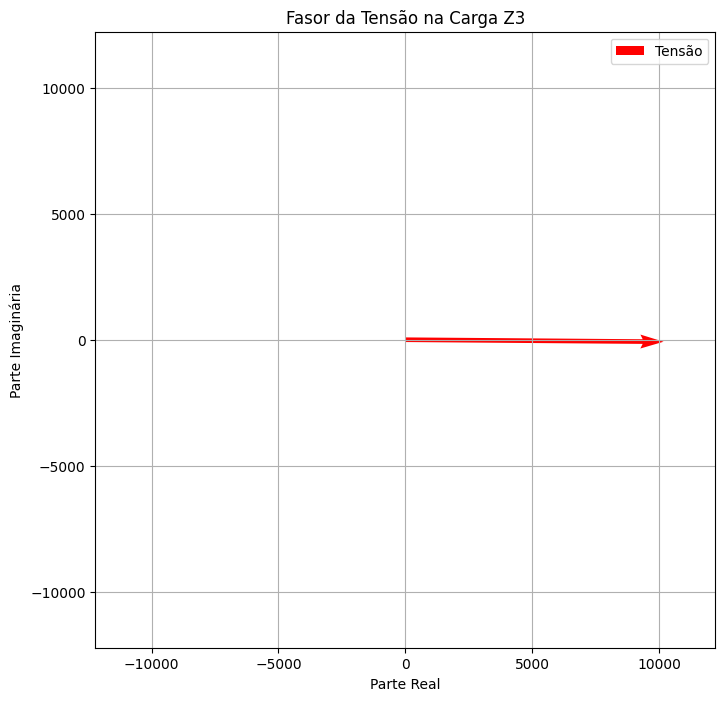

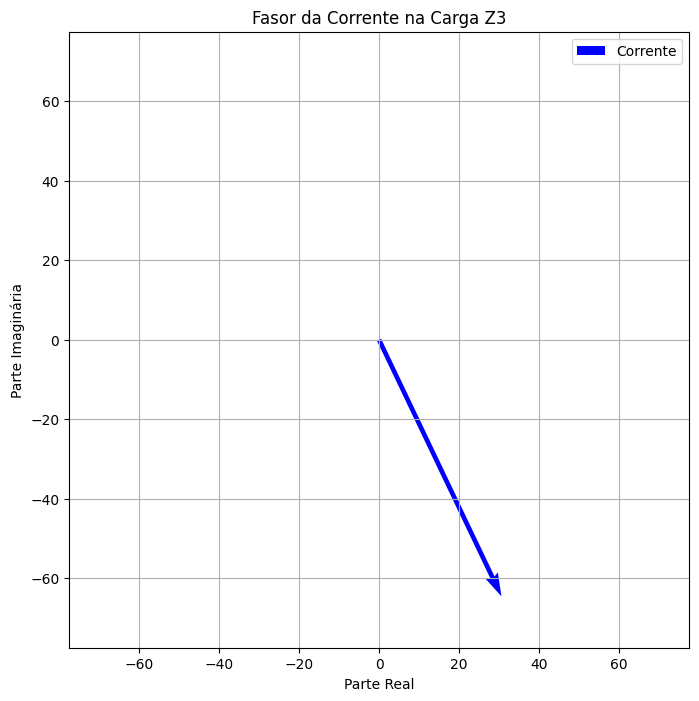

In [6]:

# Célula 6 para dois gráficos separados
def plot_fasores_separados(V, I, title_tensao, title_corrente):
    # Gráfico para a tensão
    plt.figure(figsize=(8, 8))
    plt.quiver(0, 0, np.real(V), np.imag(V), angles='xy', scale_units='xy', scale=1, color='r', label='Tensão')
    limite_tensao = 1.2 * max(abs(np.real(V)), abs(np.imag(V)))
    if limite_tensao == 0:  # Evitar limites nulos
        limite_tensao = 1
    plt.xlim(-limite_tensao, limite_tensao)
    plt.ylim(-limite_tensao, limite_tensao)
    plt.grid()
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.legend()
    plt.title(title_tensao)
    plt.show()

    # Gráfico para a corrente
    plt.figure(figsize=(8, 8))
    plt.quiver(0, 0, np.real(I), np.imag(I), angles='xy', scale_units='xy', scale=1, color='b', label='Corrente')
    limite_corrente = 1.2 * max(abs(np.real(I)), abs(np.imag(I)))
    if limite_corrente == 0:  # Evitar limites nulos
        limite_corrente = 1
    plt.xlim(-limite_corrente, limite_corrente)
    plt.ylim(-limite_corrente, limite_corrente)
    plt.grid()
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.legend()
    plt.title(title_corrente)
    plt.show()

# Chamada da função para dois gráficos
plot_fasores_separados(V_z3, I_z3, "Fasor da Tensão na Carga Z3", "Fasor da Corrente na Carga Z3")

## Seção 7: Cálculo de Potências
Cálculo das potências na carga Z3:
- **Potência Ativa (P)**: Energia útil consumida pela carga (kW).  
- **Potência Reativa (Q)**: Energia armazenada e devolvida ao sistema (kVAR).  

In [7]:
# Célula 7
def potencia_aparente(V, I):
    S = V * np.conj(I)
    return S.real, S.imag

P_z3, Q_z3 = potencia_aparente(V_z3, I_z3)
print(f"Potência Ativa (Z3): {P_z3/1e3:.2f} kW")
print(f"Potência Reativa (Z3): {Q_z3/1e3:.2f} kVAR")

Potência Ativa (Z3): 316.97 kW
Potência Reativa (Z3): 655.30 kVAR


## Seção 8: Ajuste de TAP
Cálculo do TAP ajustado para o transformador T1, de forma a garantir que a tensão de saída esteja dentro do valor desejado.

In [8]:
# Célula 8
def ajustar_tap(V_alvo, V_fonte):
    return V_fonte / V_alvo

NT1_ajustado = ajustar_tap(69e3, V_gerador)
transformadores['T1'] = matriz_transformador(**trafo_params['T1'], a=NT1_ajustado)
print(f"TAP ajustado para T1: {NT1_ajustado:.3f}")

TAP ajustado para T1: 1.000


## Seção 9: Compensação Reativa
Cálculo do capacitor necessário para compensar a potência reativa da carga Z3 e melhorar o fator de potência do sistema.

In [9]:
# Célula 9
def capacitor_derivacao(Q_necessario, V, f=60):
    Xc = V**2 / Q_necessario
    return 1 / (2 * np.pi * f * abs(Xc))

C_z3 = capacitor_derivacao(-100e3, abs(V_z3))
print(f"Capacitor para Z3: {C_z3:.6f} F")

Capacitor para Z3: 0.000003 F


## Seção 10: Resultados Finais
Resumo dos resultados obtidos:
- **Tensão na carga Z3** (kV).  
- **Corrente na carga Z3** (A).  
- **Perdas ativas no sistema** (kW).  
- **Fator de potência da carga Z3**.  

In [10]:
# Célula 10
# Calcular corrente no gerador
I_gerador = V_gerador / T_sistema[0, 1]

# Calcular potência ativa no gerador
P_gerador = abs(V_gerador) * abs(I_gerador) * np.cos(np.angle(V_gerador) - np.angle(I_gerador))

print("\n--- Resultados Finais ---")
print(f"Tensão Z3: {abs(V_z3)/1e3:.2f} kV")
print(f"Perdas Ativas: {(P_gerador - P_z3)/1e3:.2f} kW")
print(f"Fator de Potência Z3: {np.cos(np.angle(V_z3) - np.angle(I_z3)):.2f}")


--- Resultados Finais ---
Tensão Z3: 10.18 kV
Perdas Ativas: 3784.22 kW
Fator de Potência Z3: 0.44
